<a href="https://colab.research.google.com/github/Lucazere00/music_emotion_recognition/blob/main/music_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installazione delle librerie**

In [23]:
!pip install librosa --upgrade
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

!git clone https://github.com/Lucazere00/music_emotion_recognition.git

fatal: destination path 'music_emotion_recognition' already exists and is not an empty directory.


# **Import**

In [ ]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
import numpy as np
from google.colab import drive
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# **Dataset**

In [ ]:
import kagglehub

path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

100%|██████████| 1.83G/1.83G [00:25<00:00, 78.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1


In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1'
print(os.listdir(dataset_path))

audio_dir = os.path.join(dataset_path, 'DEAM_audio', 'MEMD_audio')
annotations_dir = os.path.join(dataset_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')

# verifico i paths
print("Audio Directory Path:", audio_dir)
print("Static CSV Path:", annotations_dir)

# verifico se i paths esistono
if os.path.exists(audio_dir):
    print("Audio directory exists.")
else:
    print("Audio directory does not exist!")

if os.path.exists(annotations_dir):
    print("Static CSV file exists.")
else:
    print("Static CSV file does not exist!")

['features', 'DEAM_audio', 'DEAM_Annotations']
Audio Directory Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio
Static CSV Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Audio directory exists.
Static CSV file exists.


# **Breve EDA (Exploratory data analysis)**

In [ ]:

# genero il dataframe pandas
annotations_df = pd.read_csv(annotations_dir)

# le prime istanze
print("Dataset Preview:")
print(annotations_df.head())

# informazioni
print("\nDataset Info:")
print(annotations_df.info())

# statistiche
print("\nSummary Statistics:")
print(annotations_df.describe())

Dataset Preview:
   song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.3 KB
None

Summary Statistics:
           song_id   valence_mean   valence_std   arousal_mean 

In [ ]:
# verifico se ci sono valori nulli
print(annotations_df.isna().sum())

song_id          0
 valence_mean    0
 valence_std     0
 arousal_mean    0
 arousal_std     0
dtype: int64


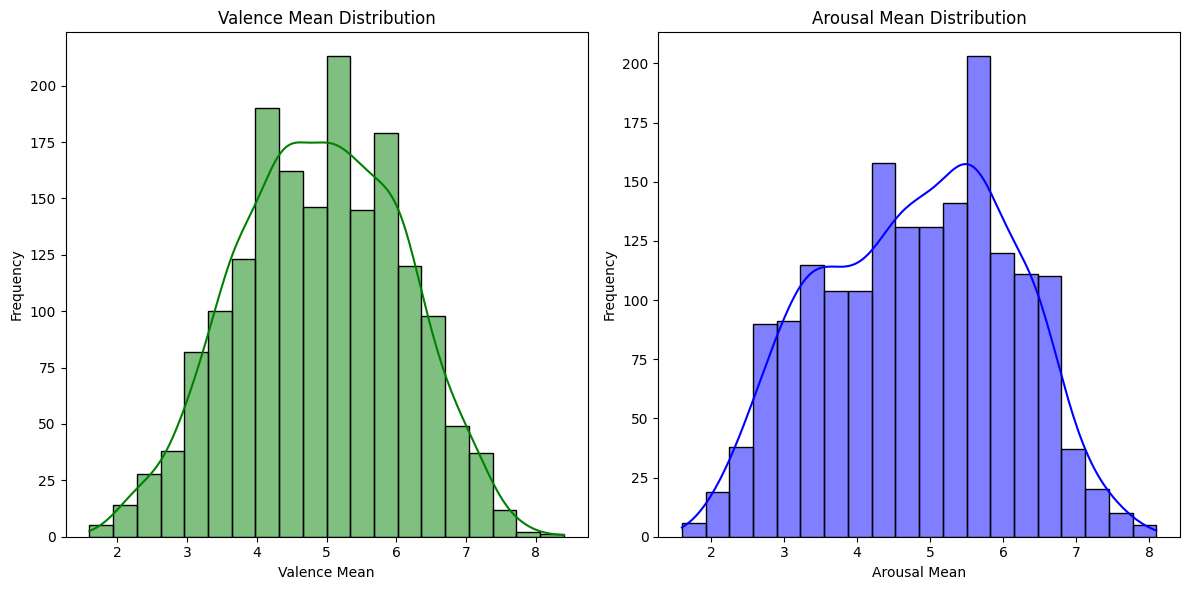

In [ ]:
plt.figure(figsize=(12, 6))

annotations_df.columns = annotations_df.columns.str.strip()

# distribuzione valence_mean
plt.subplot(1, 2, 1)
sns.histplot(annotations_df['valence_mean'], kde=True, color='green', bins=20)
plt.title('Valence Mean Distribution')
plt.xlabel('Valence Mean')
plt.ylabel('Frequency')

# # distribuzione arousal_mean
plt.subplot(1, 2, 2)
sns.histplot(annotations_df['arousal_mean'], kde=True, color='blue', bins=20)
plt.title('Arousal Mean Distribution')
plt.xlabel('Arousal Mean')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# **Costruisco le classi emozionali**

In [77]:
v_low, v_high = annotations_df['valence_mean'].quantile([0.33, 0.66])
a_low, a_high = annotations_df['arousal_mean'].quantile([0.33, 0.66])

def classes(row):
    v, a = row['valence_mean'], row['arousal_mean']

    if v >= v_high and a >= a_high:
        return 'Happy'
    elif v <= v_low and a >= a_high:
        return 'Angry'
    elif v <= v_low and a <= a_low:
        return 'Sad'
    elif v >= v_high and a <= a_low:
        return 'Relaxed'
    else:
        return 'Neutral'

annotations_df['label'] = annotations_df.apply(classes, axis=1)
print(annotations_df[['song_id', 'valence_mean', 'arousal_mean', 'label']].head(20))

print(annotations_df['label'].value_counts())

    song_id  valence_mean  arousal_mean    label
0         2           3.1           3.0      Sad
1         3           3.5           3.3      Sad
2         4           5.7           5.5  Neutral
4         7           5.8           6.4  Neutral
7        12           5.5           5.8  Neutral
8        13           3.2           4.0  Neutral
13       21           6.6           6.3    Happy
18       32           4.2           3.3  Neutral
25       43           6.7           3.5  Relaxed
33       51           3.6           3.2      Sad
36       54           3.1           3.3      Sad
38       56           6.4           5.8  Neutral
39       58           3.3           3.4      Sad
41       60           4.3           6.4  Neutral
42       62           6.2           3.9  Neutral
44       65           6.4           5.8  Neutral
45       67           7.2           6.8    Happy
47       69           3.2           3.9  Neutral
49       71           5.9           3.7  Neutral
50       72         

In [ ]:
annotations_df = annotations_df[annotations_df['label'] != 'Neutral']

In [74]:
print(annotations_df['label'].value_counts())


label
Neutral    430
Happy      211
Sad        193
Relaxed     16
Angry       13
Name: count, dtype: int64
     song_id  valence_mean  arousal_mean    label
0          2           3.1           3.0      Sad
1          3           3.5           3.3      Sad
2          4           5.7           5.5  Neutral
4          7           5.8           6.4  Neutral
7         12           5.5           5.8  Neutral
..       ...           ...           ...      ...
191      224           5.5           5.7  Neutral
192      225           3.7           4.2  Neutral
194      227           3.1           3.5      Sad
195      228           3.5           4.0  Neutral
197      231           4.1           5.6  Neutral

[100 rows x 4 columns]


# **Estrazione del Mel-Spectrogram**

In [ ]:
def extract_mel_segment(file_path, start_sec, duration=5, n_mels=128, max_len=256):
    # Carichiamo solo il segmento che ci interessa (offset e duration)
    y, sr = librosa.load(file_path, sr=22050, offset=start_sec, duration=duration)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalizzazione tra 0 e 1 (aiuta molto la CNN a convergere)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    # Padding/Cropping per assicurare che la larghezza sia max_len
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

In [ ]:
from tqdm import tqdm

X = []
y = []

# 5 segmenti da 5 secondi per TUTTI
segments = [(i * 6, 5) for i in range(5)]

for _, row in tqdm(annotations_df.iterrows(),
                   total=len(annotations_df),
                   desc="Estrazione Spettrogrammi"):

    file_path = os.path.join(audio_dir, f"{int(row['song_id'])}.mp3")
    label = row['label']

    if not os.path.exists(file_path):
        continue

    for start, dur in segments:
        try:
            mel_spec = extract_mel_segment(
                file_path,
                start_sec=start,
                duration=dur,
                max_len=256
            )
            X.append(mel_spec)
            y.append(label)

        except Exception:
            continue



Estrazione Spettrogrammi: 100%|██████████| 863/863 [03:09<00:00,  4.55it/s]


# **Preprocessing e codifica**

In [ ]:
X = np.array(X)[..., np.newaxis]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Classi mappate:", label_encoder.classes_)
print("Forma X:", X.shape) # Dovrebbe essere (N_Campioni, 128, 256, 1)

Classi mappate: ['Angry' 'Happy' 'Relaxed' 'Sad']
Forma X: (4315, 128, 256, 1)


In [ ]:
from collections import Counter
print(Counter(y))

Counter({'Happy': 1925, 'Sad': 1835, 'Angry': 295, 'Relaxed': 260})


In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(3.656779661016949), 1: np.float64(0.5603896103896104), 2: np.float64(4.149038461538462), 3: np.float64(0.587874659400545)}


In [29]:
from sklearn.model_selection import GroupShuffleSplit

groups = annotations_df['song_id'].values.repeat(5)

# Split train/test (ad esempio 20% test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y_categorical, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]




# **Definizione della rete neurale CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
model = Sequential([
    # Cambiato input_shape a 256 di larghezza
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 256, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Aggiungiamo un terzo blocco per gestire la complessità dell'audio
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Aumentato leggermente per gestire il rumore delle label
    Dense(4, activation='softmax') # Assicurati che CLASSES siano 4
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 125, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,881,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,975,492 (26.61 MB)

 Trainable params: 6,975,044 (26.61 MB)

 Non-trainable params: 448 (1.75 KB)

# **Addestramento del modello**

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weights)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.4044 - loss: 2.4776 - val_accuracy: 0.0867 - val_loss: 10.5513
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.5750 - loss: 1.3034 - val_accuracy: 0.0867 - val_loss: 14.4040
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.5717 - loss: 1.2326 - val_accuracy: 0.1006 - val_loss: 10.6683
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.5507 - loss: 1.1828 - val_accuracy: 0.3965 - val_loss: 4.4994
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.6137 - loss: 1.1486 - val_accuracy: 0.4636 - val_loss: 2.1631
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.6860 - loss: 0.9483 - val_accuracy: 0.5075 - val_loss: 1.0895
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.6698 - loss: 0.9414 - val_accuracy: 0.6867 - val_loss: 0.9346
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.6799 - loss: 0.9385 - val_a

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Salva nel formato nativo Keras (più robusto)
model_path = '/content/drive/MyDrive/music_emotion_recognition_model_2.keras'
model.save(model_path)

print(f"Modello salvato con successo in: {model_path}")

Mounted at /content/drive
Modello salvato con successo in: /content/drive/MyDrive/music_emotion_recognition_model_2.keras


In [30]:
from google.colab import drive
drive.mount('/content/drive')
# Per ricaricare il modello
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/music_emotion_recognition_model_2.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Valutazione**

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.7486 - loss: 0.7862
Accuracy sul test set: 0.74


# **Visualizzazione di alcuni Mel-Spectrogram**

# **Happy**

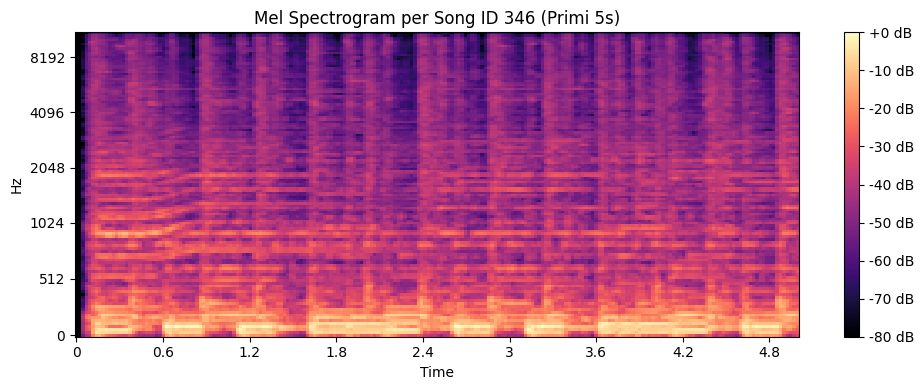

In [70]:
sample_song_id_346 = 346

file_path_346 = os.path.join(audio_dir, f"{int(sample_song_id_346)}.mp3")
y_346, sr_346 = librosa.load(file_path_346, duration=5)

# Mel Spectrogram
mel_346 = librosa.feature.melspectrogram(y=y_346, sr=sr_346, n_mels=128)
mel_db_346 = librosa.power_to_db(mel_346, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_346, x_axis='time', y_axis='mel', sr=sr_346)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram per Song ID {sample_song_id_346} (Primi 5s)')
plt.tight_layout()
plt.show()

# **Sad**

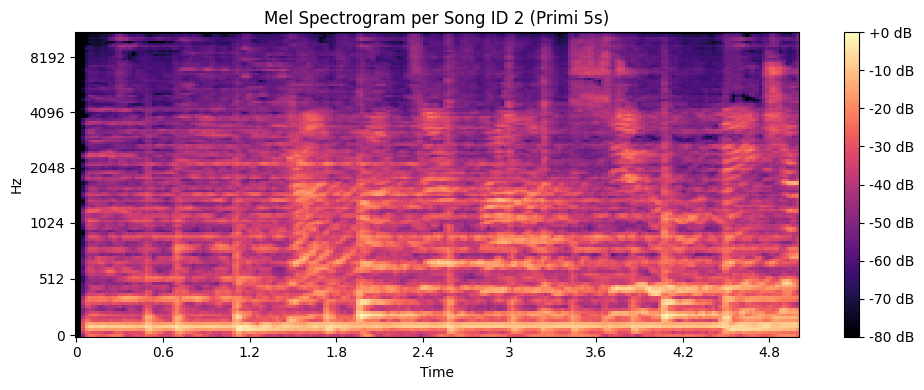

In [80]:
sample_song_id_2 = 2

file_path_2 = os.path.join(audio_dir, f"{int(sample_song_id_2)}.mp3")
y_2, sr_2 = librosa.load(file_path_2, duration=5)

# Mel Spectrogram
mel_2 = librosa.feature.melspectrogram(y=y_2, sr=sr_2, n_mels=128)
mel_db_2 = librosa.power_to_db(mel_2, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_2, x_axis='time', y_axis='mel', sr=sr_2)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram per Song ID {sample_song_id_2} (Primi 5s)')
plt.tight_layout()
plt.show()

# **Relaxed**

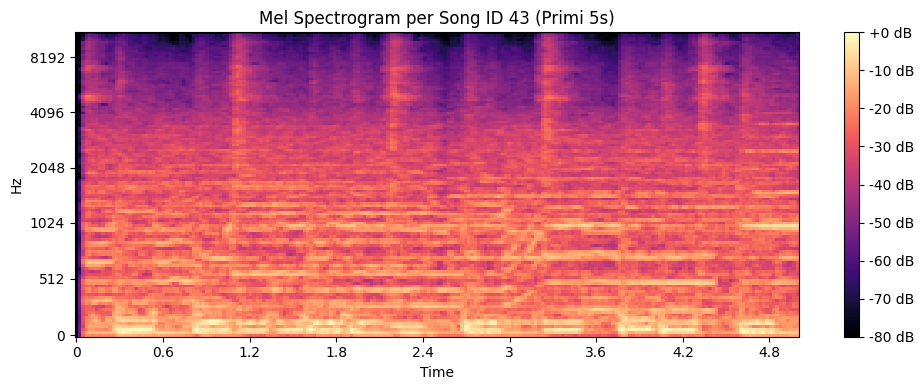

In [78]:
sample_song_id_43 = 43

file_path_43 = os.path.join(audio_dir, f"{int(sample_song_id_43)}.mp3")
y_43, sr_43 = librosa.load(file_path_43, duration=5)

# Mel Spectrogram
mel_43 = librosa.feature.melspectrogram(y=y_43, sr=sr_43, n_mels=128)
mel_db_43 = librosa.power_to_db(mel_43, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_43, x_axis='time', y_axis='mel', sr=sr_43)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram per Song ID {sample_song_id_43} (Primi 5s)')
plt.tight_layout()
plt.show()

# **Angry**

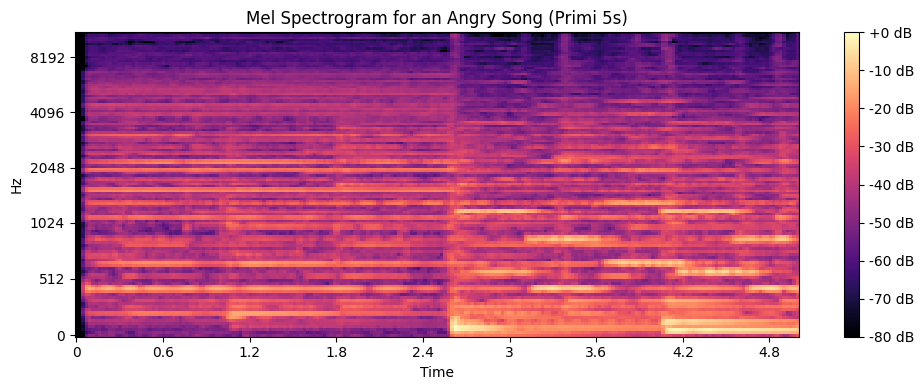

Mel-Spectrogram for the first Angry song displayed successfully.


In [81]:
sample_angry_song = annotations_df[annotations_df['label'] == 'Angry'].iloc[0]
sample_song_id_angry = int(sample_angry_song['song_id'])

file_path_angry = os.path.join(audio_dir, f"{sample_song_id_angry}.mp3")

y_angry, sr_angry = librosa.load(file_path_angry, duration=5)

# Mel Spectrogram
mel_angry = librosa.feature.melspectrogram(y=y_angry, sr=sr_angry, n_mels=128)
mel_db_angry = librosa.power_to_db(mel_angry, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_angry, x_axis='time', y_axis='mel', sr=sr_angry)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram for an Angry Song (Primi 5s)')
plt.tight_layout()
plt.show()
print("Mel-Spectrogram for the first Angry song displayed successfully.")

# **Confronto tra Mel-Spectrogram e MFCC**

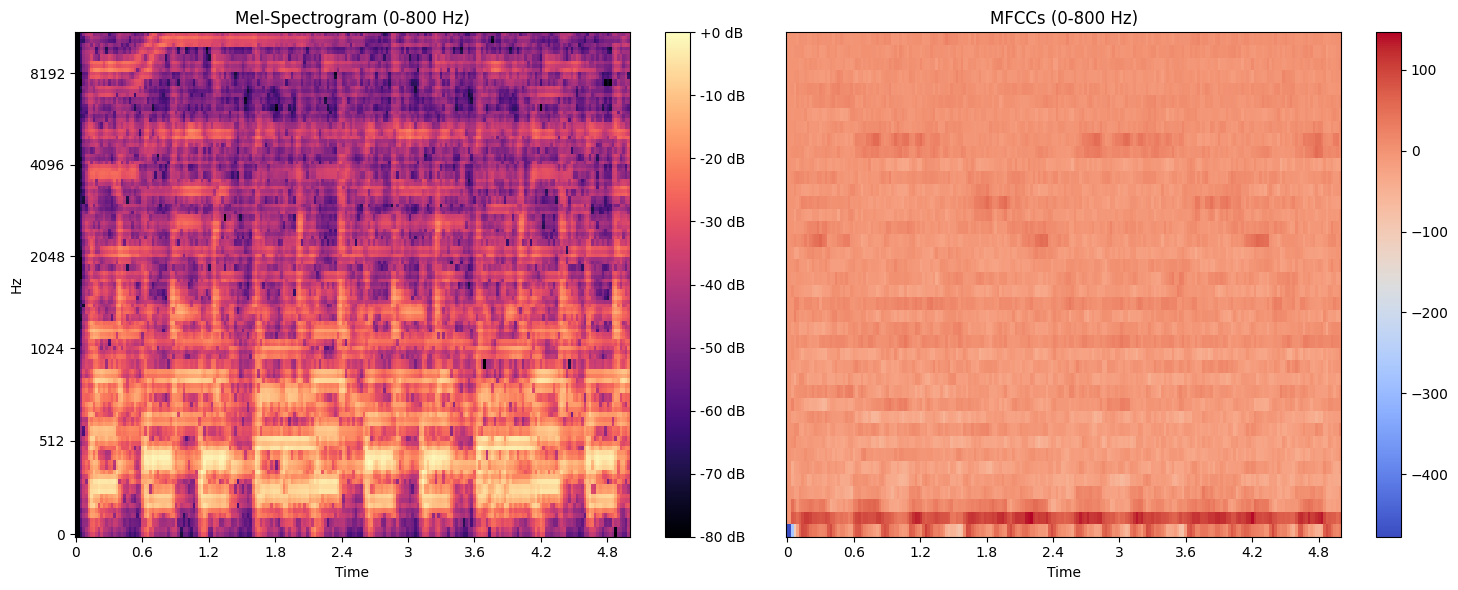

In [83]:
file_path_mfcc_comparison = file_path_346
y_mfcc_comparison, sr_mfcc_comparison = librosa.load(file_path_mfcc_comparison, duration=5)

# 2. Calculate the Mel-Spectrogram with frequency limit
mel_mfcc_comparison = librosa.feature.melspectrogram(y=y_mfcc_comparison, sr=sr_mfcc_comparison, n_mels=128, fmax=800)

# 3. Convert mel_mfcc_comparison to decibels
mel_db_mfcc_comparison = librosa.power_to_db(mel_mfcc_comparison, ref=np.max)

# 4. Calculate the MFCCs with frequency limit
mfcc_features = librosa.feature.mfcc(y=y_mfcc_comparison, sr=sr_mfcc_comparison, n_mfcc=40, fmax=800)

# 5. Create a matplotlib figure with two subplots
plt.figure(figsize=(15, 6))

# 6. Display the Mel-Spectrogram
plt.subplot(1, 2, 1)
librosa.display.specshow(mel_db_mfcc_comparison, x_axis='time', y_axis='mel', sr=sr_mfcc_comparison)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (0-800 Hz)')

# 7. Display the MFCCs
plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc_features, x_axis='time', sr=sr_mfcc_comparison)
plt.colorbar()
plt.title('MFCCs (0-800 Hz)')

# 8. Adjust layout and display plots
plt.tight_layout()
plt.show()

# **Confusion matrix**

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 767ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Progetto_Artificial_Intelligence/confusion_matrix_plot1.png'

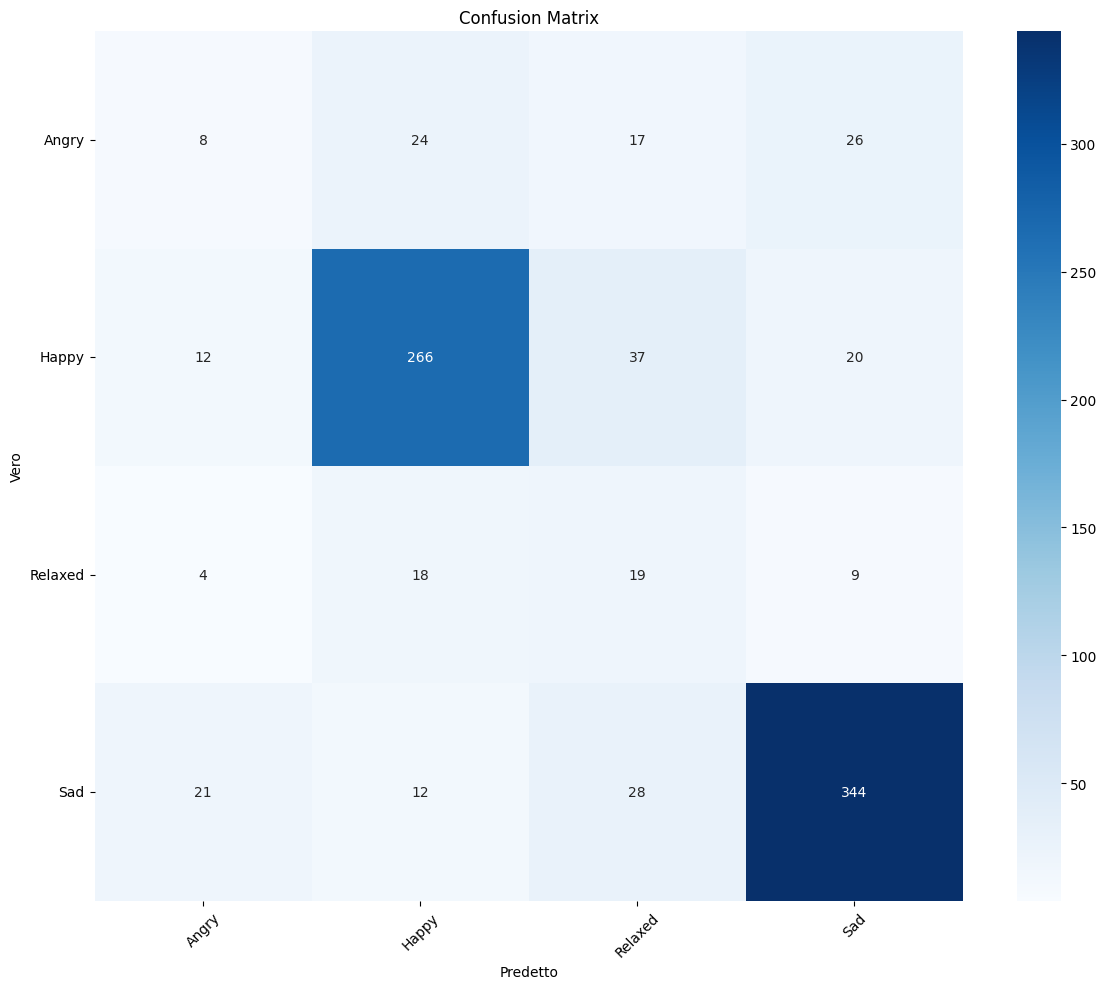

In [84]:
# Otteniamo le predizioni del modello
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcolo e visualizzazione della confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predetto")
plt.ylabel("Vero")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/confusion_matrix_plot1.png')
plt.show()

<Axes: >

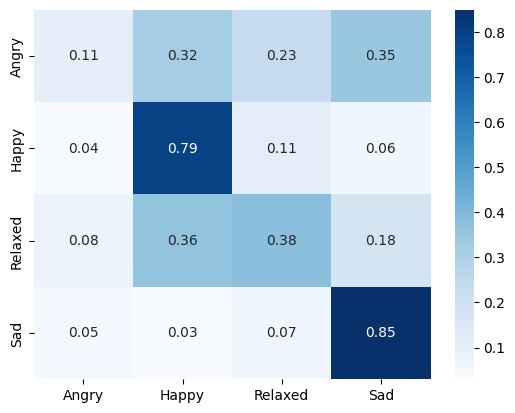

In [85]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# **Transfer Learning**